In [1]:
import torch
import numpy as np

print(torch.cuda.is_available())

torch.manual_seed(0)

False


In [2]:
def calc_deriv(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns u(x,y), computes d^2u/dx^2 using torch.autograd."""
    
    x = inputs
    laplacian = torch.zeros(x.shape[0]) #array to store values of laplacian

    for i, xi in enumerate(x):
        hess = torch.autograd.functional.hessian(model, xi.unsqueeze(0), create_graph=True)
        N = 2
        laplacian[i] = torch.diagonal(hess.view(N, N), offset=0).sum()
    
    return laplacian

In [3]:
# Mean-squared error as the comparison criterion
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    deriv_model = calc_deriv(model, inputs)
    deriv_exact = torch.zeros_like(deriv_model)
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 0
    boundary_left = inputs.detach().clone()
    boundary_left[:,0] = 0
    boundary_bottom = inputs.detach().clone()
    boundary_bottom[:,1] = 0
    boundary_right = inputs.detach().clone()
    boundary_right[:,0] = 1
    boundary_top = inputs.detach().clone()
    boundary_top[:,1] = 1

    boundary_left_model = model(boundary_left)
    boundary_left_exact = torch.sin(torch.pi * inputs[:,1]).unsqueeze(1)
    boundary_left_loss = criterion(boundary_left_model, boundary_left_exact)
    boundary_bottom_model = model(boundary_bottom)
    boundary_bottom_exact = torch.zeros_like(boundary_bottom_model)
    boundary_bottom_loss = criterion(boundary_bottom_model, boundary_bottom_exact)
    boundary_right_model = model(boundary_right)
    boundary_right_exact = np.exp(-torch.pi)*torch.sin(torch.pi * inputs[:,1]).unsqueeze(1)
    boundary_right_loss = criterion(boundary_right_model, boundary_right_exact)
    boundary_top_model = model(boundary_top)
    boundary_top_exact = torch.zeros_like(boundary_top_model)
    boundary_top_loss = criterion(boundary_top_model, boundary_top_exact)
    
    return ode_loss + boundary_left_loss + boundary_bottom_loss + boundary_right_loss + boundary_top_loss

In [4]:
from qadence import feature_map, hea, chain, add, kron
from qadence import QNN, QuantumCircuit, Z
from qadence.types import BasisSet, ReuploadScaling

n_qubits = 3
depth = 3

# Feature map
fm_x = feature_map(
    n_qubits = n_qubits,
    param = "x",
    fm_type = BasisSet.CHEBYSHEV,
    reupload_scaling = ReuploadScaling.TOWER,
)

fm_y = feature_map(
    n_qubits = n_qubits,
    param = "y",
    fm_type = BasisSet.CHEBYSHEV,
    reupload_scaling = ReuploadScaling.TOWER,
)

# Ansatz
ansatz = hea(n_qubits = n_qubits, depth = depth)

# Observable
observable = add(Z(i) for i in range(n_qubits))

circuit = QuantumCircuit(n_qubits, chain(fm_x, fm_y, ansatz))
model = QNN(circuit = circuit, observable = observable, inputs = ["x", "y"])

In [5]:
n_epochs = 50

xmin = 0
xmax = 0.999
x_points = 4
ymin = 0
ymax = 0.999
y_points = 4

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(n_epochs):
    print(epoch)
    optimizer.zero_grad()

    # Training data. We unsqueeze essentially making each batch have a single x value.
    xy_train = torch.stack((xmin + (xmax-xmin)*torch.rand(x_points, y_points, requires_grad = True),
           ymin + (ymax-ymin)*torch.rand(x_points, y_points, requires_grad = True))).swapdims(0, 2).flatten(end_dim=1)

    loss = loss_fn(inputs = xy_train, model = model)
    loss.backward()
    optimizer.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


C:\Users\Gabriele\anaconda3\envs\qadence\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


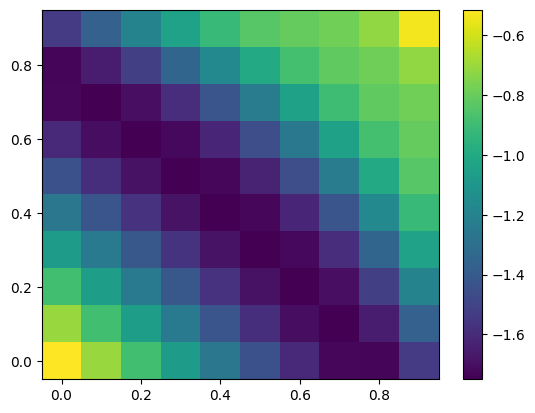

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# result_exact = f_exact(x_test).flatten()
x = torch.arange(xmin, xmax, 0.1)
xy_test = torch.cartesian_prod(x, x)

X, Y = torch.meshgrid(x, x)

result_model = model(xy_test).detach().unflatten(0,(x.shape[0], x.shape[0]))

# plt.plot(x_test, result_exact, label = "Exact solution")
plt.pcolormesh(X.detach().numpy(), Y.detach().numpy(), result_model.squeeze(2).detach().numpy(), label = " Trained model")
plt.colorbar()